# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time
import operator

from tensorflow.keras import Sequential
from tensorflow.keras import layers

from shapely import geometry 
from simplification.cutil import (
    simplify_coords,
    simplify_coords_idx,
    simplify_coords_vw,
    simplify_coords_vw_idx,
    simplify_coords_vwp,
)

/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passi

# Define Functions

In [2]:
def PolyArea(x,y):
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

def ScoreFormula(old_number_of_datapoints, new_number_of_datapoints, processing_time):
    return (1 - (new_number_of_datapoints / old_number_of_datapoints)) * (1 - processing_time)

def ScaleFactor(all_geometries):
    b_list = []
    
    for geometries in all_geometries:
        coordinates = []
        for element in geometries[9:-2].split(','):
            coordinates.append(list(map(float,element.split(' '))))
        
        
        polygon = geometry.Polygon(coordinates)
        centroid = np.array(polygon.centroid)
        coordinates = np.vstack(coordinates)
        
        b = coordinates - centroid
        b_min = np.min(b)
        b_max = np.max(b)
        b_list.append(b_min)
        b_list.append(b_max)
        
    return np.std(b_list)
    
def Normalize_Geometry(coordinates1, scale_factor):
    polygon = geometry.Polygon(coordinates1)
    centroid = np.array(polygon.centroid)
    coordinates2 = np.vstack(coordinates1)
    
    return (coordinates2 - centroid) / scale_factor

def Add_One_Hot(normalized_geometry):
    normalized_geometry = np.insert(normalized_geometry, 2, 1, axis=1)
    normalized_geometry = np.insert(normalized_geometry, 3, 0, axis=1)
    normalized_geometry = np.insert(normalized_geometry, 4, 0, axis=1)
    normalized_geometry[len(normalized_geometry)-1,2] = 0
    normalized_geometry[len(normalized_geometry)-1,4] = 1
    
    return normalized_geometry

def Add_Zero_Padding(one_hotted_geometry, max_length):
    boundary = max_length - len(one_hotted_geometry)
    zero_matrix = np.zeros([boundary,5])
    return np.append(one_hotted_geometry, zero_matrix, axis=0)

# Load Data

In [3]:
data = pd.read_csv('/Users/davemeijdam/Documents/Data Science/Master/Master Thesis/Data/Sample data/ONTWIKKELBUURTEN.csv', sep =';')

# Pre Processing

In [4]:
simplify_possibilities = [['D-P', 0.005], ['D-P', 0.001], ['D-P', 0.0005], ['D-P', 0.0001],
                         ['D-P', 0.00005], ['D-P', 0.00001], ['V-W', 0.000005],
                         ['V-W', 0.000001], ['V-W', 0.0000005], ['V-W', 0.0000001], ['V-W', 0.00000005], 
                         ['V-W', 0.00000001]]

MAX_LENGTH_DEFICIT = -0.1

In [5]:
results_list = []
length_list = []

# Decide order from longest polygon to smallest polygon
for row in data['WKT_LNG_LAT']:
    coordinates = []
    
    
    for element2 in row[9:-2].split(','):
        coordinates.append(list(map(float,element2.split(' '))))
    length_list.append([coordinates, len(coordinates)])

length_list.sort(key=operator.itemgetter(1), reverse=True)

for element in length_list:
    results_dict = {}
    poly1 = geometry.Polygon(element[0])
    print(element[1])
    results = []
    for possibility in simplify_possibilities:

        if possibility[0] == 'D-P':
            # Simplification function Douglas-Peucker
            time_start = time()
            simplified_coordinates = simplify_coords(element[0], possibility[1])
            time_end = time()
            process_time = time_end - time_start

        if possibility[0] == 'V-W':
            # Simplification function Visvalingam-Whyatt
            time_start = time()
            simplified_coordinates = simplify_coords_vw(element[0], possibility[1])
            time_end = time()
            process_time = time_end - time_start
        
        
        poly2 = geometry.Polygon(simplified_coordinates)
        length_deficit = (poly2.length - poly1.length) / poly1.length
        
        # If the length deficit of the polygon is smaller(greater) than the provided MAX_LENGTH_DEFICIT, 
        # the score gets saved
        if length_deficit > MAX_LENGTH_DEFICIT:
            score = ScoreFormula(len(element[0]), len(simplified_coordinates), process_time)
            results.append(score)
    
    results_dict['polygon'] = Add_Zero_Padding(Add_One_Hot(Normalize_Geometry(element[0], ScaleFactor(data['WKT_LNG_LAT']))), len(length_list[0][0]))
    results_dict['algorithm'] = results.index(max(results))
    results_list.append(results_dict)
    
print(results_list)

X = []
y = []

for element in results_list:
    X.append(element['polygon'])
    y.append(element['algorithm'])
X = np.array(X)
y = np.array(y)
# Calculate the deficit in the number of 
#point_deficit = len(coordinates) - len(simplified_coordinates)
#print('Point Deficit: ' + str(point_deficit) + ' out of ' + str(len(coordinates)))

#old_area = PolyArea(old_xs,old_ys)
#new_area = PolyArea(new_xs,new_ys)
#area_deficit_percentage = (new_area - old_area) / old_area
#print(area_deficit_percentage)

124
113
99
95
83
67
64
59
54
52
36
35
29
29
29
15
14
11
6
[{'polygon': array([[-1.3035057 ,  0.27693582,  1.        ,  0.        ,  0.        ],
       [-1.15769521,  0.1255716 ,  1.        ,  0.        ,  0.        ],
       [-1.10932733,  0.06791385,  1.        ,  0.        ,  0.        ],
       [-1.07994308,  0.04216477,  1.        ,  0.        ,  0.        ],
       [-0.8897028 , -0.16503961,  1.        ,  0.        ,  0.        ],
       [-0.87223381, -0.17947929,  1.        ,  0.        ,  0.        ],
       [-0.84507106, -0.2194661 ,  1.        ,  0.        ,  0.        ],
       [-0.54002016, -0.55622371,  1.        ,  0.        ,  0.        ],
       [-0.49599428, -0.60812578,  1.        ,  0.        ,  0.        ],
       [-0.46974032, -0.63306705,  1.        ,  0.        ,  0.        ],
       [-0.28424595, -0.83572747,  1.        ,  0.        ,  0.        ],
       [-0.22810285, -0.79977973,  1.        ,  0.        ,  0.        ],
       [-0.20619088, -0.78665275,  1.    

In [30]:
# Select index of simplification possibility
INDEX = 6


possibility = simplify_possibilities[INDEX]

if possibility[0] == 'D-P':
    # Simplification function Douglas-Peucker
    simplified_coordinates = simplify_coords(coordinates, possibility[1])

if possibility[0] == 'V-W':
    # Simplification function Visvalingam-Whyatt
    simplified_coordinates = simplify_coords_vw(coordinates, possibility[1])

old_xs, old_ys = zip(*coordinates)
new_xs, new_ys = zip(*simplified_coordinates)

print(len(simplified_coordinates))
print(len(coordinates))

13
95


# Plotting

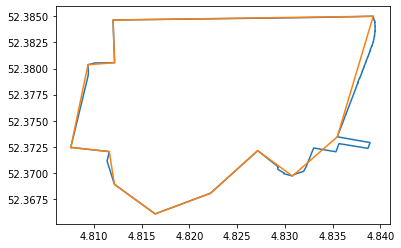

In [31]:
plt.figure()
plt.plot(old_xs, old_ys)
plt.plot(new_xs, new_ys)
plt.show()

# Model

In [134]:
input_shape = X[0].shape
print(input_shape)
model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling1D(3,3))

model.add(layers.Conv1D(64, 5, activation='relu'))
model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dense(len(simplify_possibilities), activation='softmax'))

print(model.summary())

(124, 5)
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 120, 32)           832       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 40, 32)            0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 36, 64)            10304     
_________________________________________________________________
global_average_pooling1d_3 ( (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 12)                780       
Total params: 11,916
Trainable params: 11,916
Non-trainable params: 0
_________________________________________________________________
None


In [136]:
model.compile(loss='sparse_categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 400
EPOCHS = 50

history = model.fit(X,
                    y,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.2,
                    verbose=1)

Train on 15 samples, validate on 4 samples
Epoch 1/50
15/15 [==============================] - 1s 82ms/sample - loss: 2.4584 - acc: 0.5333 - val_loss: 2.4756 - val_acc: 0.2500
Epoch 2/50
15/15 [==============================] - 0s 2ms/sample - loss: 2.4262 - acc: 0.5333 - val_loss: 2.4726 - val_acc: 0.2500
Epoch 3/50
15/15 [==============================] - 0s 3ms/sample - loss: 2.3947 - acc: 0.5333 - val_loss: 2.4693 - val_acc: 0.2500
Epoch 4/50
15/15 [==============================] - 0s 3ms/sample - loss: 2.3627 - acc: 0.5333 - val_loss: 2.4656 - val_acc: 0.2500
Epoch 5/50
15/15 [==============================] - 0s 9ms/sample - loss: 2.3301 - acc: 0.5333 - val_loss: 2.4615 - val_acc: 0.2500
Epoch 6/50
15/15 [==============================] - 0s 2ms/sample - loss: 2.2967 - acc: 0.5333 - val_loss: 2.4568 - val_acc: 0.2500
Epoch 7/50
15/15 [==============================] - 0s 2ms/sample - loss: 2.2624 - acc: 0.5333 - val_loss: 2.4517 - val_acc: 0.2500
Epoch 8/50
15/15 [==============

In [137]:
y

array([ 5,  5,  0,  5,  0,  6,  5,  0,  0,  5,  0,  0,  4,  0,  0,  1,  0,
        6, 10])

array([[3.31131905e-01, 2.37713961e-04, 8.58559360e-05, 1.59744202e-04,
        6.52712712e-04, 6.46050692e-01, 1.99019685e-02, 6.53166935e-05,
        9.80822253e-04, 9.53198760e-05, 3.07499344e-04, 3.30454262e-04],
       [5.62220991e-01, 1.17724296e-04, 3.59925689e-05, 6.94715127e-05,
        4.60388022e-04, 4.24918622e-01, 1.11434953e-02, 2.17761190e-05,
        6.41414255e-04, 5.36331681e-05, 1.79218521e-04, 1.37254174e-04],
       [3.23837191e-01, 3.90632427e-04, 1.47721003e-04, 3.01360735e-04,
        1.02584076e-03, 6.43413246e-01, 2.79267672e-02, 1.35334238e-04,
        1.62073306e-03, 1.71938998e-04, 4.90228762e-04, 5.39006374e-04],
       [1.86471090e-01, 2.29978497e-04, 7.82966308e-05, 1.75153400e-04,
        5.00369002e-04, 7.86554992e-01, 2.43066903e-02, 8.19672714e-05,
        8.99095437e-04, 8.00911803e-05, 2.63782829e-04, 3.58506222e-04],
       [8.70796144e-01, 1.29545821e-04, 3.94026429e-05, 6.81622259e-05,
        7.42667995e-04, 1.20773382e-01, 6.23105792e-03, 1.81